In [204]:
import warnings
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
print(ig.__version__)

0.7.1


In [279]:
class CellTypeNet(object):
    def __init__(self, cell_types):
        self.graph = ig.Graph(directed=True)
        self.graph.es['markers'] = None
        self.graph.vs['markers'] = None
        self.has_canonical_marker = False
        self.add_cell_types(cell_types)
        self._epsilon = 1e-4
    
    def add_cell_type(self, cell_type: str, intentional=False):
        try:
            self.graph.vs.find(name=cell_type)
            warnings.warn('Duplicate cell type, ignored')
        except ValueError:
            self.graph.add_vertices(cell_type)
    
    def add_cell_types(self, cell_types):
        for cell_type in cell_types:
            self.add_cell_type(cell_type)
    
    def add_canonical_marker(self, marker_gene, cell_type, relationship):
        try:
            v = self.graph.vs.find(name=cell_type)
        except ValueError:
            raise ValueError("Unknown cell type " + cell_type)
        
        if relationship is None or relationship == '+':
            rel = 1.
        elif relationship == '-':
            rel = 0.
        elif isinstance(relationship, float) and relationship <= 1. and relationship >= 0.:
            rel = relationship
        else:
            raise ValueError("Relationship must be '+' (by default if omitted), '-', or a float value in [0., 1.].")
        if v['markers'] is None:
            v['markers'] = {marker_gene: rel}
        else:
            v['markers'][marker_gene] = rel
        
    def add_pairwise_marker(self, marker_gene, cell_type, relationship, other_cell_type):
        try:
            self.graph.vs.find(name=cell_type)
        except ValueError:
            raise ValueError("Unknown cell type " + cell_type)
        try:
            self.graph.vs.find(name=other_cell_type)
        except ValueError:
            raise ValueError("Unknown cell type " + other_cell_type)

        eid = self.graph.get_eid(cell_type, other_cell_type, error=False)
        if eid < 0:
            self.graph.add_edge(cell_type, other_cell_type)
            eid = self.graph.get_eid(cell_type, other_cell_type, error=False)

        if relationship == '>':
            rel = 1.
        elif relationship == '<':
            rel = 0.
        elif relationship == '=':
            rel = 0.5
        elif isinstance(relationship, float) and relationship <= 1. and relationship >= 0.:
            rel = relationship
        else:
            raise ValueError("Relationship must be '>', '<', '=', or a float value in [0., 1.].")

        if self.graph.es[eid]['markers'] is None:
            self.graph.es[eid]['markers'] = {marker_gene: rel}
        else:
            self.graph.es[eid]['markers'][marker_gene] = rel
    
    def add_marker(self, marker_gene, cell_type, relationship = None, other_cell_type = None):
        if other_cell_type is None:
            self.add_canonical_marker(marker_gene, cell_type, relationship)
        else:
            self.add_pairwise_marker(marker_gene, cell_type, relationship, other_cell_type)
    
    def plot(self, interp='symbol', max_length = None, *args, **kwargs):
        if interp == 'symbol':
            interp = self._float_to_symbol
        elif interp == 'float':
            interp = self._float_to_str

        self.graph.vs['label'] = [self._canonical_marker_to_str(*i, max_length, interp) for i in zip(self.graph.vs['name'], self.graph.vs['markers'])]
        self.graph.es['label'] = [self._pairwise_marker_to_str(i, max_length, interp) for i in self.graph.es['markers']]

        return ig.plot(self.graph, *args, **kwargs)
    
    def complete(self):
        for e in self.graph.es:
            other_eid = self.graph.get_eid(e.target, e.source, error=False)
            if other_eid < 0:
                self.graph.add_edge(e.target, e.source)
                other_eid = self.graph.get_eid(e.target, e.source, error=False)
            for marker_gene, rel in e['markers'].items():
                if self.graph.es[other_eid]['markers'] is None:
                    self.graph.es[other_eid]['markers'] = {marker_gene: 1 - rel}
                else:
                    if marker_gene in self.graph.es[other_eid]['markers']:
                        if abs(self.graph.es[other_eid]['markers'][marker_gene] - (1 - rel)) > self._epsilon:
                            raise ValueError('Contradiction for marker ' + marker_gene + ' between ' + 
                                             e.source['name'] + ' and ' + e.target['name'] + '.')
                    self.graph.es[other_eid]['markers'][marker_gene] = 1 - rel
    
    def get_canonical_markers(self, cell_type):
        return self.graph.vs.find(name=cell_type)['markers']
    
    def get_pairwise_markers(self, cell_type, other_cell_type=None):
        if other_cell_type is not None:
            return self.graph.es[self.graph.get_eid(cell_type, other_cell_type)]['markers']
        else:
            return {self.graph.vs[self.graph.es[eid].target]['name']: self.graph.es[eid]['markers'] 
                    for eid in net.graph.incident(cell_type, mode='out')}
            
    
    @staticmethod
    def _float_to_symbol(v):
        if v < 0.2: return '--'
        elif v < 0.4: return '-'
        elif v < 0.6: return '='
        elif v < 0.8: return '+'
        else: return '++'
    
    @staticmethod
    def _float_to_str(v):
        return ' %.2f' % v
    
    @staticmethod
    def _pairwise_marker_to_str(markers, max_length, interp):
        if markers is None:
            return None
        if max_length is None or len(markers) <= max_length:
            return '\n'.join(k + interp(v) for k, v in markers.items())
        else:
            return '\n'.join(k + interp(v) for k, v in list(markers.items())[:max_length])
        
    @staticmethod
    def _canonical_marker_to_str(name, markers, max_length, interp):
        if markers is None:
            return name
        if max_length is None or len(markers) <= max_length:
            return name + ': ' + ', '.join(k + interp(v) for k, v in markers.items())
        else:
            return name + ': ' + ', '.join(k + interp(v) for k, v in list(markers.items())[:max_length])

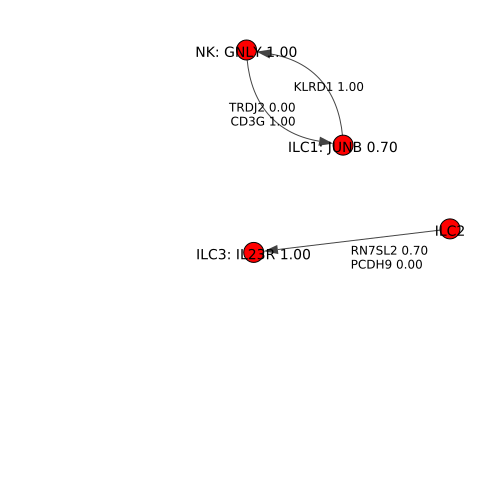

In [280]:
net = CellTypeNet(['ILC1', 'ILC2', 'ILC3', 'NK'])

net.add_marker('GNLY', 'NK')
net.add_marker('JUNB', 'ILC1', 0.7)
net.add_marker('IL23R', 'ILC3')

net.add_marker('TRDJ2', 'ILC1', '<', 'NK')
net.add_marker('KLRD1', 'NK', '>', 'ILC1')
net.add_marker('CD3G', 'ILC1', '>', 'NK')
net.add_marker('RN7SL2', 'ILC2', 0.7, 'ILC3')
net.add_marker('PCDH9', 'ILC2', '<', 'ILC3')
               
net.plot(interp='float', layout = g.layout("kk"), bbox = (500, 500), margin = 50)

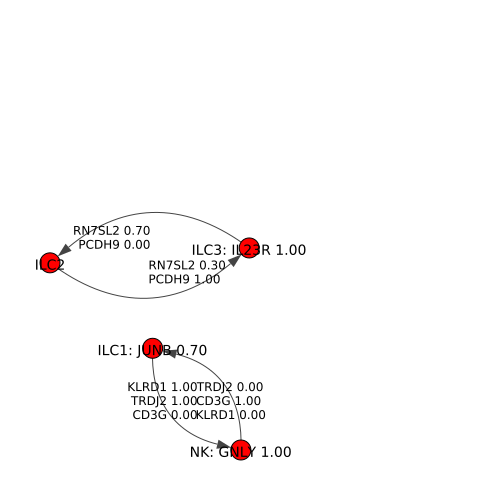

In [286]:
net.complete()
net.plot(interp='float', layout = g.layout("kk"), bbox = (500, 500), margin = 50)

In [282]:
net.get_canonical_markers('ILC3')

{'IL23R': 1.0}

In [283]:
net.get_pairwise_markers('ILC3')

{'ILC2': {'RN7SL2': 0.30000000000000004, 'PCDH9': 1.0}}

In [ ]:
# First match edges
# Rule: 